# 1. Importing Libraries

In [7]:
##   Project: Action Recognition using CNN + LSTM (UCF50 - 18 classes)
##  Goal: Classify videos based on actions using deep learning (TimeDistributed CNN + LSTM)

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical , plot_model
from tensorflow.keras.optimizers import Adam

# 2. Define Classes and Paths

In [8]:
# Define the 18 selected action classes
selected_classes = [
    "Basketball",
    "Diving",
    "HorseRace",
    "JumpRope",
    "VolleyballSpiking",
    "WalkingWithDog",
    "BenchPress",
    "Biking",
    "GolfSwing",
    "HighJump",
    "Kayaking",
    "PullUps",
    "PushUps",
    "RopeClimbing",
    "SkateBoarding",
    "SoccerJuggling",
    "Swing",
    "TrampolineJumping"
]


# UCF50 dataset path
dataset_path = "/kaggle/input/realistic-action-recognition-ucf50/UCF50"

# Confirm folder structure
for cls in selected_classes:
    print(f"{cls} → Total videos:", len(os.listdir(os.path.join(dataset_path, cls))))

Basketball → Total videos: 137
Diving → Total videos: 153
HorseRace → Total videos: 127
JumpRope → Total videos: 148
VolleyballSpiking → Total videos: 116
WalkingWithDog → Total videos: 123
BenchPress → Total videos: 160
Biking → Total videos: 145
GolfSwing → Total videos: 142
HighJump → Total videos: 123
Kayaking → Total videos: 157
PullUps → Total videos: 120
PushUps → Total videos: 106
RopeClimbing → Total videos: 130
SkateBoarding → Total videos: 120
SoccerJuggling → Total videos: 156
Swing → Total videos: 137
TrampolineJumping → Total videos: 119


# 3. EDA – Show Sample Frames from Each Class

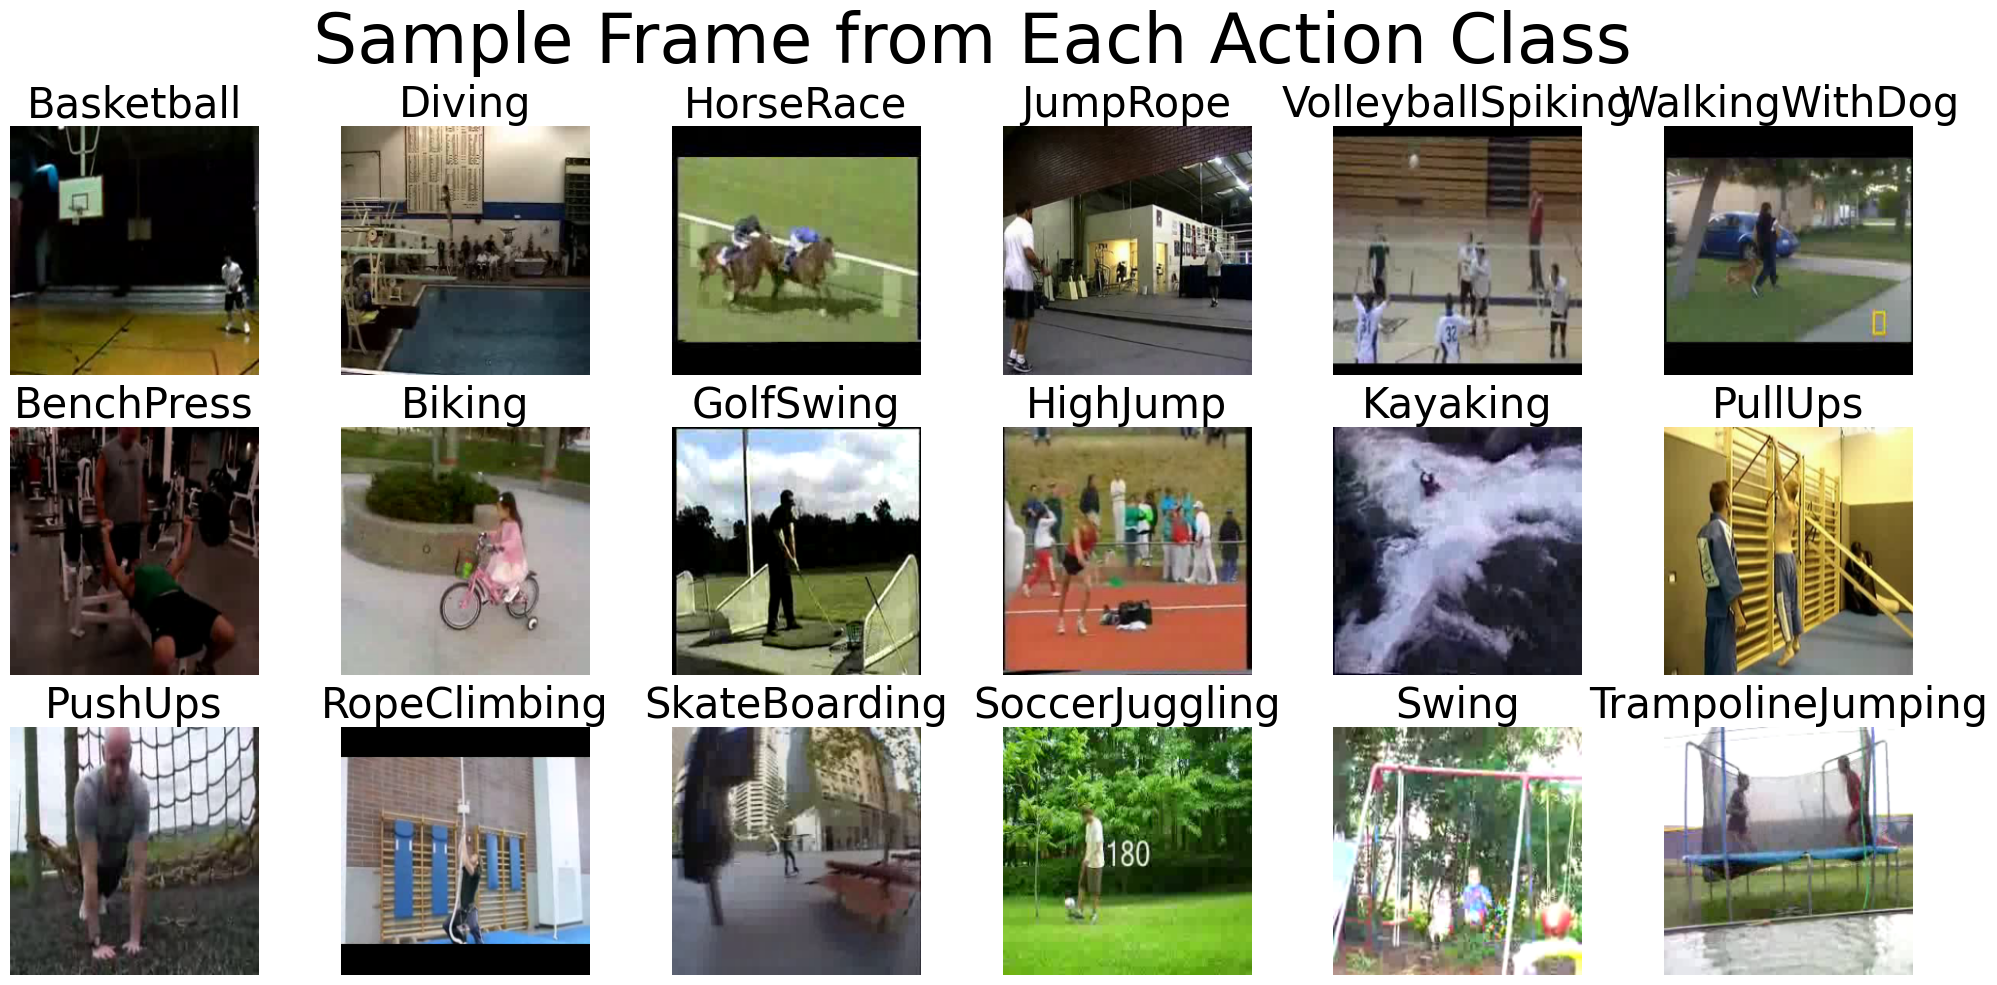

In [9]:
# Show 1 frame from 1 video of each class

def show_sample_frames(classes, dataset_path):
    fig, axes = plt.subplots(3, 6, figsize=(20, 10))  # 3 rows and 6 columns
    axes = axes.flatten()  # make it easy to loop over

    for i, cls in enumerate(classes):
        # Load first video from the class folder
        video_path = os.path.join(dataset_path, cls, os.listdir(os.path.join(dataset_path, cls))[0])
        cap = cv2.VideoCapture(video_path) #think of cap like a video player that's paused and ready to play frame by frame.

        # ret: a boolean (True/False) — it’s True if a frame was read successfully
        # frame: the actual image/frame (as a NumPy array)
        ret, frame = cap.read()
        cap.release() # This closes the video file after you're done

        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, (256, 256))
            axes[i].imshow(frame)
            axes[i].set_title(cls , fontsize = 30)
        axes[i].axis('off')    

    plt.suptitle(" Sample Frame from Each Action Class", fontsize=50)
    plt.tight_layout()
    plt.show()

# Calling
show_sample_frames(selected_classes, dataset_path)

# 4. Extract Frames from Videos

In [10]:
#  Extract fixed number of frames from each video
# For simplicity and speed, we’ll extract 20 frames per video

def extract_frames(video_path, num_frames=20):
    frames = []
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_interval = max(total_frames // num_frames, 1)
    
    count = 0
    while len(frames) < num_frames and cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if count % frame_interval == 0:
            frame = cv2.resize(frame, (64, 64))
            frame = frame / 255.0  # Normalize pixel values
            frames.append(frame)
        count += 1
    cap.release()

    # Pad with last frame if video too short
    while len(frames) < num_frames:
        frames.append(frames[-1])
    
    return np.array(frames)

# 5. Load Videos and Create Dataset

In [11]:
# Loop through videos in selected classes and extract frames
X = []
y = []

for class_index, cls in enumerate(selected_classes):
    class_path = os.path.join(dataset_path, cls)
    videos = os.listdir(class_path)  

    for video in videos:
        video_path = os.path.join(class_path, video)
        frames = extract_frames(video_path, num_frames=20)
        if frames.shape == (20, 64, 64, 3):  # Ensure consistent shape
            X.append(frames)
            y.append(class_index)

X = np.array(X)
y = to_categorical(y) # One-Hot

print(" Data Loaded:")
print("X shape:", X.shape)  # (samples, time_steps, height, width, channels)
print("y shape:", y.shape)  # (samples, num_classes)

 Data Loaded:
X shape: (2419, 20, 64, 64, 3)
y shape: (2419, 18)


# 6. Train-Test Split

In [13]:
# Cell6: Train/Test Split + Normalization + Augmentation


from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Normalize pixel values
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Data augmentation (only for training set)
datagen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=10,
    zoom_range=0.1
)

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")


Training samples: 1935, Testing samples: 484


# 7. Build CNN + LSTM Model with TimeDistributed

In [14]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, TimeDistributed, BatchNormalization, Input
from keras.optimizers import Adam
from keras.utils import plot_model

#  Model = CNN applied on each frame using TimeDistributed + LSTM for sequence learning

model = Sequential()

#CNN-Layers
model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu', padding='same'), input_shape=(20, 64, 64, 3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(2,2)))
model.add(TimeDistributed(Dropout(0.25)))

model.add(TimeDistributed(Conv2D(64, (3,3), activation='relu', padding='same')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(2,2)))
model.add(TimeDistributed(Dropout(0.25)))

model.add(TimeDistributed(Flatten()))

# LSTM Layer
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(18, activation='softmax'))

# Compile
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-08-31 07:31:58.647533: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


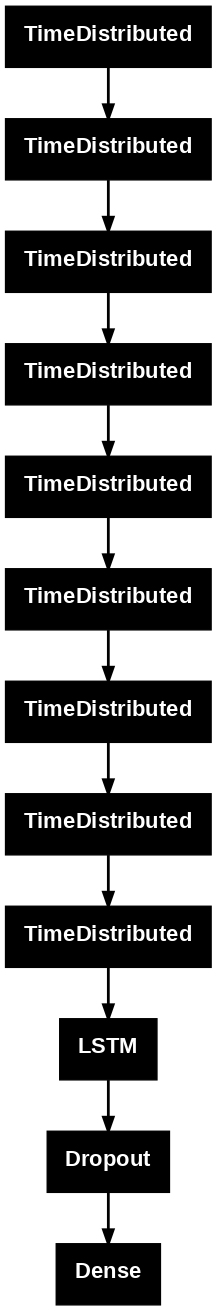

In [15]:
plot_model(model,dpi=100)

# 8. Train the Model

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
import os

#  Define callbacks
checkpoint = ModelCheckpoint(
    'best_model.h5',          # file to save best weights
    monitor='val_loss',       # monitor validation loss
    verbose=1,
    save_best_only=True,      # only save if improved
    mode='min'
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1
)

callbacks = [checkpoint, early_stop, reduce_lr]


# Resume model if saved
if os.path.exists('best_model.h5'):
    print("Found saved model. Loading weights and resuming training...")
    model = load_model('best_model.h5')
else:
    print("No saved model found. Training from scratch.")


# Train the model
history = model.fit(
    X_train, y_train,
    epochs=30,                    
    validation_data=(X_test, y_test),
    batch_size=4,
    callbacks=callbacks
)

No saved model found. Training from scratch.
Epoch 1/30
484/484 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1612 - loss: 2.7326
Epoch 1: val_loss improved from inf to 1.98311, saving model to best_model.h5
484/484 ━━━━━━━━━━━━━━━━━━━━ 1149s 2s/step - accuracy: 0.1614 - loss: 2.7322 - val_accuracy: 0.4112 - val_loss: 1.9831 - learning_rate: 5.0000e-04
Epoch 2/30
484/484 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3552 - loss: 2.1255
Epoch 2: val_loss improved from 1.98311 to 1.91887, saving model to best_model.h5
484/484 ━━━━━━━━━━━━━━━━━━━━ 1119s 2s/step - accuracy: 0.3552 - loss: 2.1255 - val_accuracy: 0.4525 - val_loss: 1.9189 - learning_rate: 5.0000e-04
Epoch 3/30
484/484 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4137 - loss: 1.8940
Epoch 3: val_loss improved from 1.91887 to 1.77268, saving model to best_model.h5
484/484 ━━━━━━━━━━━━━━━━━━━━ 1101s 2s/step - accuracy: 0.4137 - loss: 1.8939 - val_accuracy: 0.5021 - val_loss: 1.7727 - learning_rate: 5.0000e-04
Epoch 4/30
484/48

# 9. Plot Accuracy and Loss

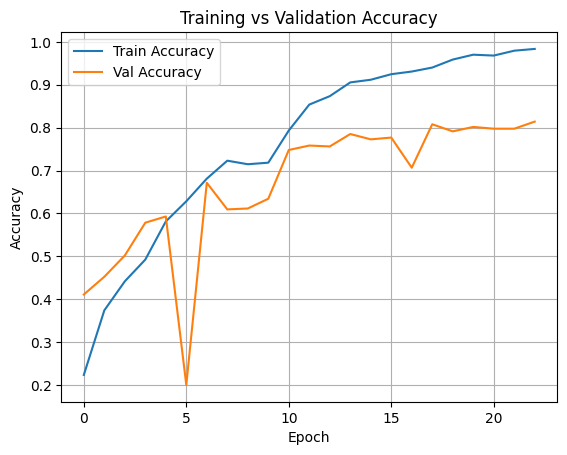

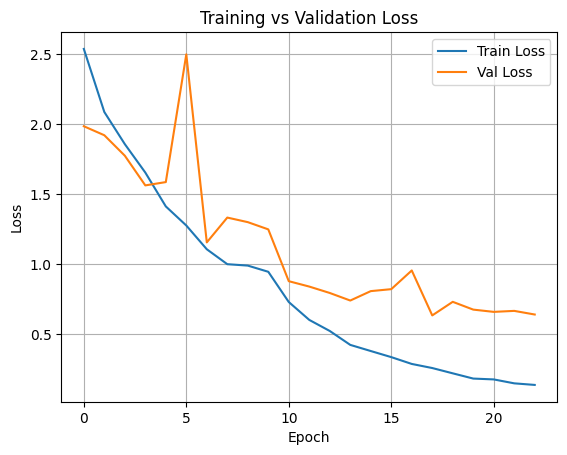

In [17]:
#  Training vs Validation Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

#  Training vs Validation Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# 10. Show Model Predictions on 5 Random Test Videos

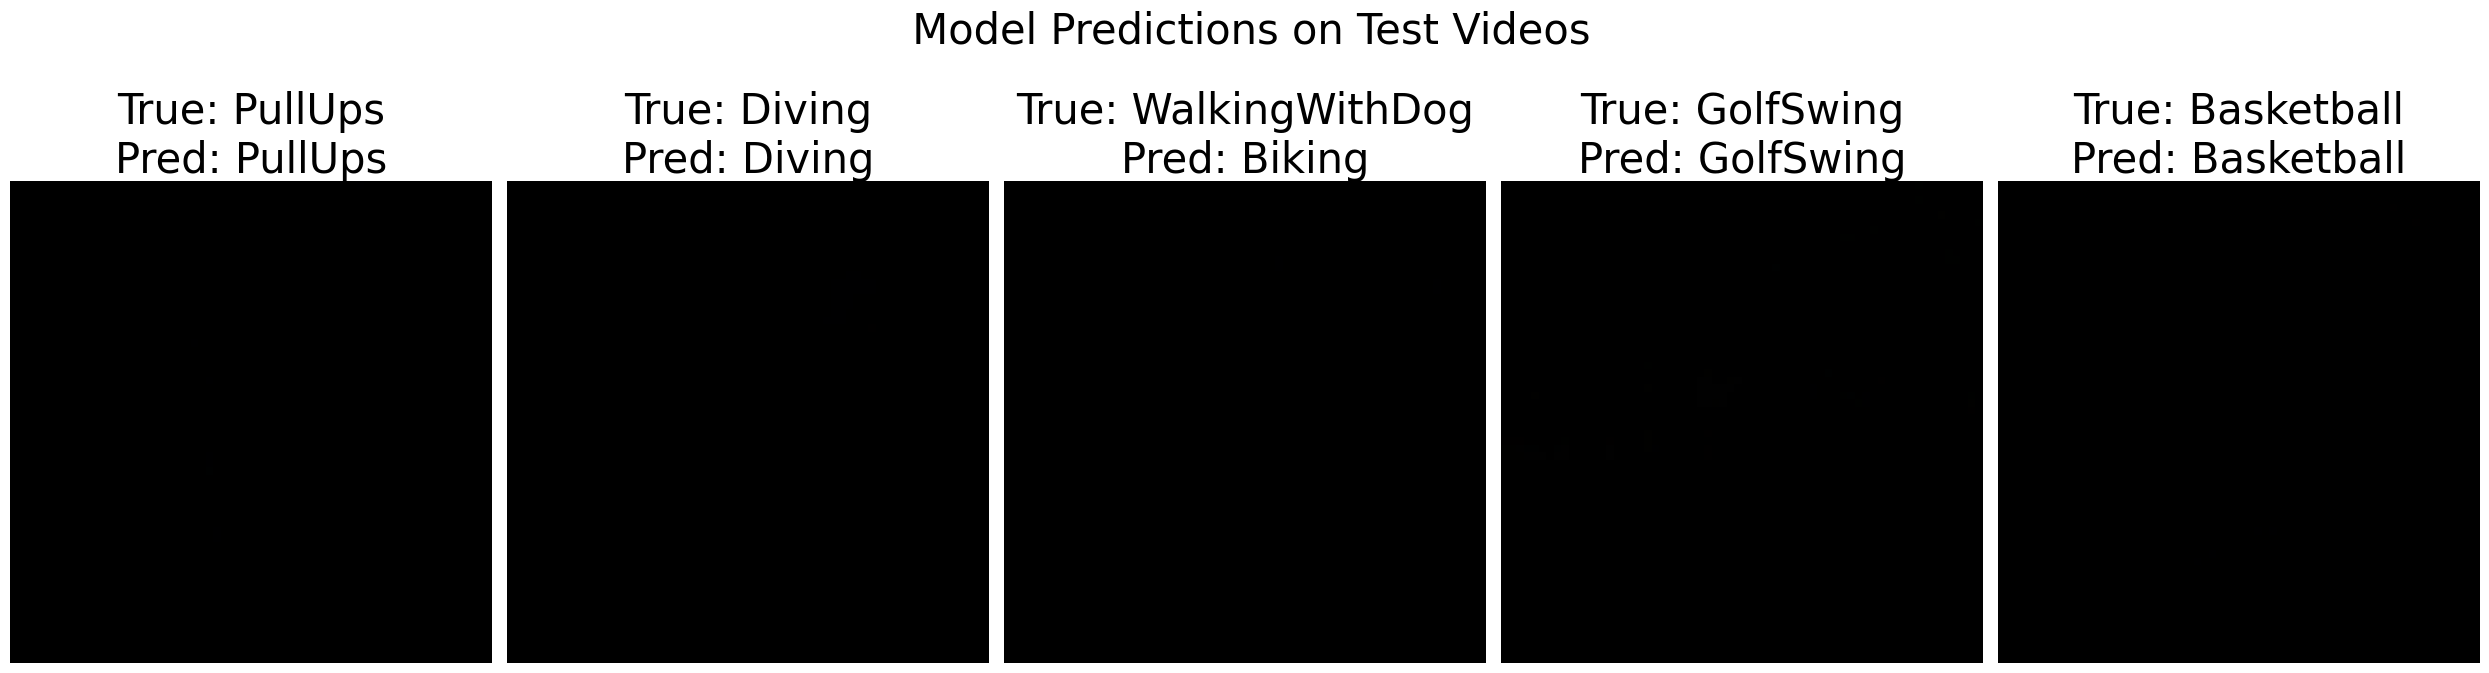

In [19]:
#  Visualize model predictions on 5 test videos (larger images)
def show_predictions(model, X_test, y_test, class_names):
    # Get 5 random indices
    indices = np.random.choice(len(X_test), 5, replace=False)
    
    # Bigger canvas size
    fig, axes = plt.subplots(1, 5, figsize=(25, 8))  #  Wider and taller

    for i, idx in enumerate(indices):
        video = X_test[idx]
        true_label = class_names[np.argmax(y_test[idx])]

        # Predict
        prediction = model.predict(np.expand_dims(video, axis=0), verbose=0)
        predicted_label = class_names[np.argmax(prediction)]

        # Get middle frame and denormalize
        mid_frame = video[len(video) // 2]
        mid_frame = (mid_frame * 255).astype(np.uint8)

        # Optional: remove resizing if frame is already big enough
        # frame = cv2.resize(mid_frame, (256, 256))  # or skip this
        frame = mid_frame  # Show full original frame size

        # Plot
        axes[i].imshow(frame)
        axes[i].set_title(f"True: {true_label}\nPred: {predicted_label}", fontsize=30)
        axes[i].axis('off')

    plt.suptitle(" Model Predictions on Test Videos", fontsize=30)
    plt.tight_layout()
    plt.show()

#  Run it
show_predictions(model, X_test, y_test, selected_classes)

## Final Take:

we can improve it by:
1. Using more video samples
2. Using data augmentation or 3D CNNs
3. Trying all 50 classes in UCF50
